# lw-ensemble

Estimate the clear-sky downward longwave using several different methods. 

Test and compare those to measured downward longwave at the CUES site to try and identify cloud-cover (especially at night).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats

%matplotlib inline

# define the lw methods

adapted from MATLAB script by Mark Raleigh, Ryan Currier

Define some ancillary functions:

In [2]:
def eo(To,RH):
    '''Calculate actual vapor pressure [kPa] from T [K] and RH [%]'''
    es = 6.108 * np.exp(17.27 * T / (T + 237.3)) # saturated vapor pressure [hPa]
    return (RH/100 * es) / 10 # actual vapor pressure [kPa]

def prata1996_w(To,RH):
    '''from Prata 1996'''
    return (465 * eo(To,RH)) / To # note: corrected equation constant to be 465 instead of 4650 (error in Flerchinger Table 1 footnote c)

def L(e,T):
    '''Calculate radiance given an emissivity and temperature [K]'''
    sb = 5.67 * (10**-8)        # Stefan-Boltzmann constant (J/s/m^2/K^4)
    return e * sb * T**4

Define LW method functions:

In [3]:
def angstrom1918(To,RH):
    '''Angstrom (1918)'''
    a = 0.83
    b = 0.18 
    c = 0.67  # note: corrected coefficient c to be 0.67 instead of 0.067 (error in Flerchinger Table 1)
    e_clr = (a - b*10**(-1*c*eo(To,RH)))
    return L(e_clr,To)

def brunt1932(To,RH):
    '''Brunt (1932)'''
    a = 0.52
    b = 0.205
    e_clr = (a + b*np.sqrt(eo(To,RH)))
    return L(e_clr,To)

def brutsaert1975(To,RH):
    '''Brutsaert (1975)'''
    a = 1.723
    b = (1/7)
    e_clr = a * (eo(To,RH)/To)**(b);
    return L(e_clr,To)

def garratt1992(To,RH):
    '''Garratt (1992)'''
    a = 0.79
    b = 0.17
    c = 0.96
    e_clr = a - b*np.exp(-1*c*eo(To,RH));
    return L(e_clr,To)

def idsojackson1969(To,RH):
    '''Idso and Jackson (1969) (Idso-1)'''
    a = 0.261
    b = 0.00077
    e_clr = 1 - a*np.exp(-1*b*(To-273.16)**2);
    return L(e_clr,To)

def idso1981(To,RH):
    '''Idso (1981) (Idso-2)'''
    a = 0.70
    b = 5.95 * 10**-4
    c = 1500
    e_clr = a + (b*eo(To,RH)*np.exp(c/To));
    return L(e_clr,To)

def iziomon2003(To,RH,elev):
    '''Iziomon et al. (2003)'''
    a = 0.35
    b = 100
    c = 212 # a,b,c for a low land site (were c = elevation in m)
    d = 0.43
    e = 115
    f = 1489 # d,e,f for a higher elevation site (were f = elevation in m)
    Mxz = (d-a)/(f-c) # change in first parameters with elevation change
    Myz = (e-b)/(f-c) # change in second parameters with elevation change
    X = Mxz*(elev - c) + a
    Y = Myz*(elev - c) + b
    e_clr = 1 - X*np.exp(-Y*eo(To,RH)/To)
    return L(e_clr,To)

def keding1989(To,RH):
    '''Keding (1989)'''
    a = 0.92
    b = 0.7
    c = 1.2
    e_clr = a - b*10**(-1*c*eo(To,RH));
    return L(e_clr,To)

def niemela2001(To,RH):
    '''Niemela et al. (2001)'''
    a = 0.72
    b = 0.09
    c = 0.2
    d = 0.76
    e_clr = a + b*(eo(To,RH)-c);
    e_clr[eo(To,RH)<c] = a - d*(eo(To,RH)[eo(To,RH)<c]-c);
    return L(e_clr,To)

def prata1996(To,RH):
    '''Prata (1996)'''
    a = 1.2
    b = 3
    c = 0.5
    e_clr = 1 - (1+prata1996_w(To,RH))*np.exp(-1*(a + b*prata1996_w(To,RH))**c);
    return L(e_clr,To)

def satturlund1979(To,RH):
    '''Satturlund (1979)'''
    a = 1.08
    b = 2016
    e_clr = a*(1-np.exp(-((10*eo(To,RH))**(To/b))));  # note: corrected so that b paramter is in the exponent ^(To/b), error in Flerchinger Table 1
    return L(e_clr,To)

def swinbank1963(To):
    '''Swinbank (1963)'''
    a = 5.31 * (10**-13)
    b = 6
    Lclr = a*(To**b);
    return Lclr

def dilleyobrien1998(To, RH):
    '''Dilley and O’Brien (1998)'''
    a = 59.38
    b = 113.7
    c = 96.96
    Lclr = a + b*(To/273.16)**6 + c*np.sqrt(prata1996_w(To,RH)/2.5) # note: corrected to be 2.5 instead of 25 (error in Flerchinger Table 1)
    return Lclr

def maykutchurch1973(To):
    '''Maykut and Church (1973)'''
    a = 0.7855
    e_clr = a;
    return L(e_clr,To)

def konzelmann1994(To,RH):
    '''Konzelmann et al. (1994)'''
    a = 0.23 # clear-sky emittance of a completely dry atmosphere (calcualted by LOWTRAN7)
    b = 0.443 # corrected from 0.484
    c = (1/8) #  corrected from 1.8
    e_clr = a + b*(1000*eo(To,RH)/To)**c; # why is there a factor of 1000 in there? unit conversion from kPa?
    return L(e_clr,To)

def campbellnorman1998(To):
    '''Campbell and Norman (1998) as cited by Walter et al (2005)'''
    a = 0.72 - 0.005*273.15 # modified so To is in (K) instead of (C) ....should be -0.6458 after the maths...
    b = 0.005
    e_clr = a + b*To;
    return L(e_clr,To)

#def longturner2008(To,RH,Qsi):
#    '''Long and Turner (2008) - based on Brutsaert (1975)'''
#    # simplify the k-value determination - use one value for day, one for
#    # night (where night/day is based on threshold in Qsi data)
#    kd = 1.18 # daytime k value, varies diurnally (and likely spatially) - see Fig 2 
#    kn = 1.28 # nighttime k value
#    a = np.mean([1.39e-11, 3.36e-12, 1.47e-11, 4.07e-12]) # "a" coefficient - average of four datasets
#    b = np.mean([4.8769, 5.1938, 4.8768, 5.1421]) # "b" coefficient - average of four datasets
#    c = (1/7) # Brutsaert (1975) exponent
    
    
    k_array = np.ones_like(To) * kd # set all values to daytime k
    k_array[Qsi<50] = kn      # set night time values to night k

    Ccoeff = k_array + a*(RH)**b
    e_clr = Ccoeff * (eo(To,RH)*10/To)**c;      # eo(To,TH) times 10 to convert from kPa to mb
    return L(e_clr,To)

def ohmura1982(To):
    '''Ohmura (1982) as cited by Howard and Stull 2013'''
    a = 8.733 * 10**-3
    b = 0.788
    e_clr = a * To**(b);
    return L(e_clr,To)

def efimova1961(To,RH):
    '''Efimova (1961) as cited by Key et al (1996)'''
    a = 0.746
    b = 0.0066 * 10 # multiply by 10 to account for eo in mb isntead of kPa
    e_clr = a + b*eo(To,RH);
    return L(e_clr,To)


---
# Test these LW functions:

#### Import observations from CUES site:

In [4]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

Open CUES temperature data files, and concatenate them together

In [5]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\CUES\Level 1 - Database\temperature'
cues_temp_files = getListOfFiles(directory)

cues_temp_data = []
_ = [cues_temp_data.append(pd.read_csv(i)) for i in cues_temp_files]
cues_temp_data = pd.concat(cues_temp_data)

# Convert the 'DateTime' text strings to pandas datetime objects
cues_temp_data['datetime']  = pd.to_datetime(cues_temp_data['MeasDateTime'])

# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_cues_temp_data = cues_temp_data.set_index('datetime')
_cues_temp_data.sort_index(inplace=True)
cues_ds = _cues_temp_data.to_xarray()

# drop old time field
cues_ds = cues_ds.drop_vars(names='MeasDateTime')

Open CUES radiation data file(s):

In [6]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\CUES\Level 1 - Database\radiation'
cues_rad_files = getListOfFiles(directory)

cues_rad_data = []
_ = [cues_rad_data.append(pd.read_csv(i)) for i in cues_rad_files]
cues_rad_data = pd.concat(cues_rad_data)

# Convert the 'DateTime' text strings to pandas datetime objects
cues_rad_data['datetime']  = pd.to_datetime(cues_rad_data['MeasDateTime'])

# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_cues_rad_data = cues_rad_data.set_index('datetime')
_cues_rad_data.sort_index(inplace=True)
cues_rad = _cues_rad_data.to_xarray()
cues_rad = cues_rad.drop_vars(names='MeasDateTime')

Load GOES observations for the CUES site

In [7]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\pkl\CUES'
goes_files = getListOfFiles(directory)

goes = []
_ = [goes.append(pd.read_pickle(i)) for i in goes_files]
goes = pd.concat(goes)

# Change GOES time values from UTC to UTC-7 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC'})
goes['datetime'] = goes['timeUTC'] - pd.Timedelta(hours=7)
goes = goes.drop(columns=['timeUTC'])

# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('datetime')
_goes.sort_index(inplace=True)
_goes = _goes.loc[~_goes.index.duplicated(keep='first')] # there are duplicates somewhere in the GOES data, remove them
_goes = _goes.loc[_goes.index >= pd.datetime(2017,2,28)]# there's also some values before 2017, remove them
goes_ds = _goes.to_xarray()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


#### Run ensemble of all these LW estimation methods:

Set up input variables from CUES observations:

In [8]:
RH = cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)']
T = cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']
To = T + 273.15 # temperature [K]
Qsi = cues_rad['upward looking solar radiation; uplooking Eppley Lab precision spectral pyranometer; (Watts/meter^2)']
elev = 3000

Run the ensemble and add results of each run to a dataset:

In [9]:
lw_ensemble = xr.Dataset()
lw_ensemble['Lclr_angstrom1918'] = angstrom1918(To,RH)
lw_ensemble['Lclr_brunt1932'] = brunt1932(To,RH)
lw_ensemble['Lclr_brutsaert1975'] = brutsaert1975(To,RH)
lw_ensemble['Lclr_garratt1992'] = garratt1992(To,RH)
lw_ensemble['Lclr_idsojackson1969'] = idsojackson1969(To,RH)
lw_ensemble['Lclr_idso1981'] = idso1981(To,RH)
lw_ensemble['Lclr_iziomon2003'] = iziomon2003(To,RH,elev)
lw_ensemble['Lclr_keding1989'] = keding1989(To,RH)
lw_ensemble['Lclr_niemela2001'] = niemela2001(To,RH)
lw_ensemble['Lclr_prata1996'] = prata1996(To,RH)
lw_ensemble['Lclr_satturlund1979'] = satturlund1979(To,RH)
lw_ensemble['Lclr_swinbank1963'] = swinbank1963(To)
lw_ensemble['Lclr_dilleyobrien1998'] = dilleyobrien1998(To,RH)
lw_ensemble['Lclr_maykutchurch1973'] = maykutchurch1973(To)
lw_ensemble['Lclr_konzelmann1994'] = konzelmann1994(To,RH)
lw_ensemble['Lclr_campbellnorman1998'] = campbellnorman1998(To)
lw_ensemble['Lclr_ohmura1982'] = ohmura1982(To)
lw_ensemble['Lclr_efimova1961'] = efimova1961(To,RH)

Take the mean, min, max of the ensemble:

In [10]:
Lclr_mean = lw_ensemble.to_array(dim='new').mean('new')
Lclr_min = lw_ensemble.to_array(dim='new').min('new')
Lclr_max = lw_ensemble.to_array(dim='new').max('new')
lw_ensemble = lw_ensemble.assign(Lclr_mean=Lclr_mean)
lw_ensemble = lw_ensemble.assign(Lclr_min=Lclr_min)
lw_ensemble = lw_ensemble.assign(Lclr_max=Lclr_max)

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Add all the results to the CUES Radiation dataset:

In [11]:
cues_rad = xr.merge([cues_rad, lw_ensemble])

---
# Plot results:

Set up font sizes for plot

In [12]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

For each estimation method, plot the estimated clear-sky LWd versus observed all-sky LWd:

In [13]:
# Function for making these plots
def plot_2dhist_LWensemble(x,y_,row,col):
    # Drop NaN values between the two datasets
    df1 = pd.DataFrame({'x': x})
    df1['y'] = y_
    #df1.fillna(df1.mean(), inplace=True) # filling nan with the mean so I can keep the same shape as I start with
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Fit a linear function to x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    fit = slope*x + intercept

    # Make "heatmap" 2d histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=200)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Plot heatmap
    ax[row,col].imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
    # Add colorbar
    #ax[row,col].colorbar(label='number of records')
    #plt.plot(x, fit, ':r')
    #plt.plot(x,y,'.k',alpha=0.05)
    ax[row,col].plot([0,400],[0,400],'-',c='grey')
    ax[row,col].text(110,370,'$r^2$={}'.format(np.round(r_value**2,2)))
    ax[row,col].text(110,355,'$B$={}'.format(np.round(np.mean(y)-np.mean(x),2)))
    ax[row,col].set_xlim([100,400])
    ax[row,col].set_ylim([100,400])
    ax[row,col].set_ylabel('LWd Estimated [$Wm^{-2}$]')
    ax[row,col].set_xlabel('LWd Observed [$Wm^{-2}$]');
    ax[row,col].set_title('LWd Observed vs\n {}'.format(y_.name))
    return None

In [14]:
x = cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
y = [cues_rad.Lclr_angstrom1918,cues_rad.Lclr_brunt1932,cues_rad.Lclr_brutsaert1975,cues_rad.Lclr_garratt1992,
     cues_rad.Lclr_idsojackson1969, cues_rad.Lclr_idso1981,cues_rad.Lclr_iziomon2003,cues_rad.Lclr_keding1989,
     cues_rad.Lclr_niemela2001,cues_rad.Lclr_prata1996,cues_rad.Lclr_satturlund1979,cues_rad.Lclr_swinbank1963,
     cues_rad.Lclr_dilleyobrien1998,cues_rad.Lclr_maykutchurch1973,cues_rad.Lclr_konzelmann1994,
     cues_rad.Lclr_campbellnorman1998,cues_rad.Lclr_ohmura1982,cues_rad.Lclr_efimova1961,
     cues_rad.Lclr_mean, cues_rad.Lclr_min, cues_rad.Lclr_max]

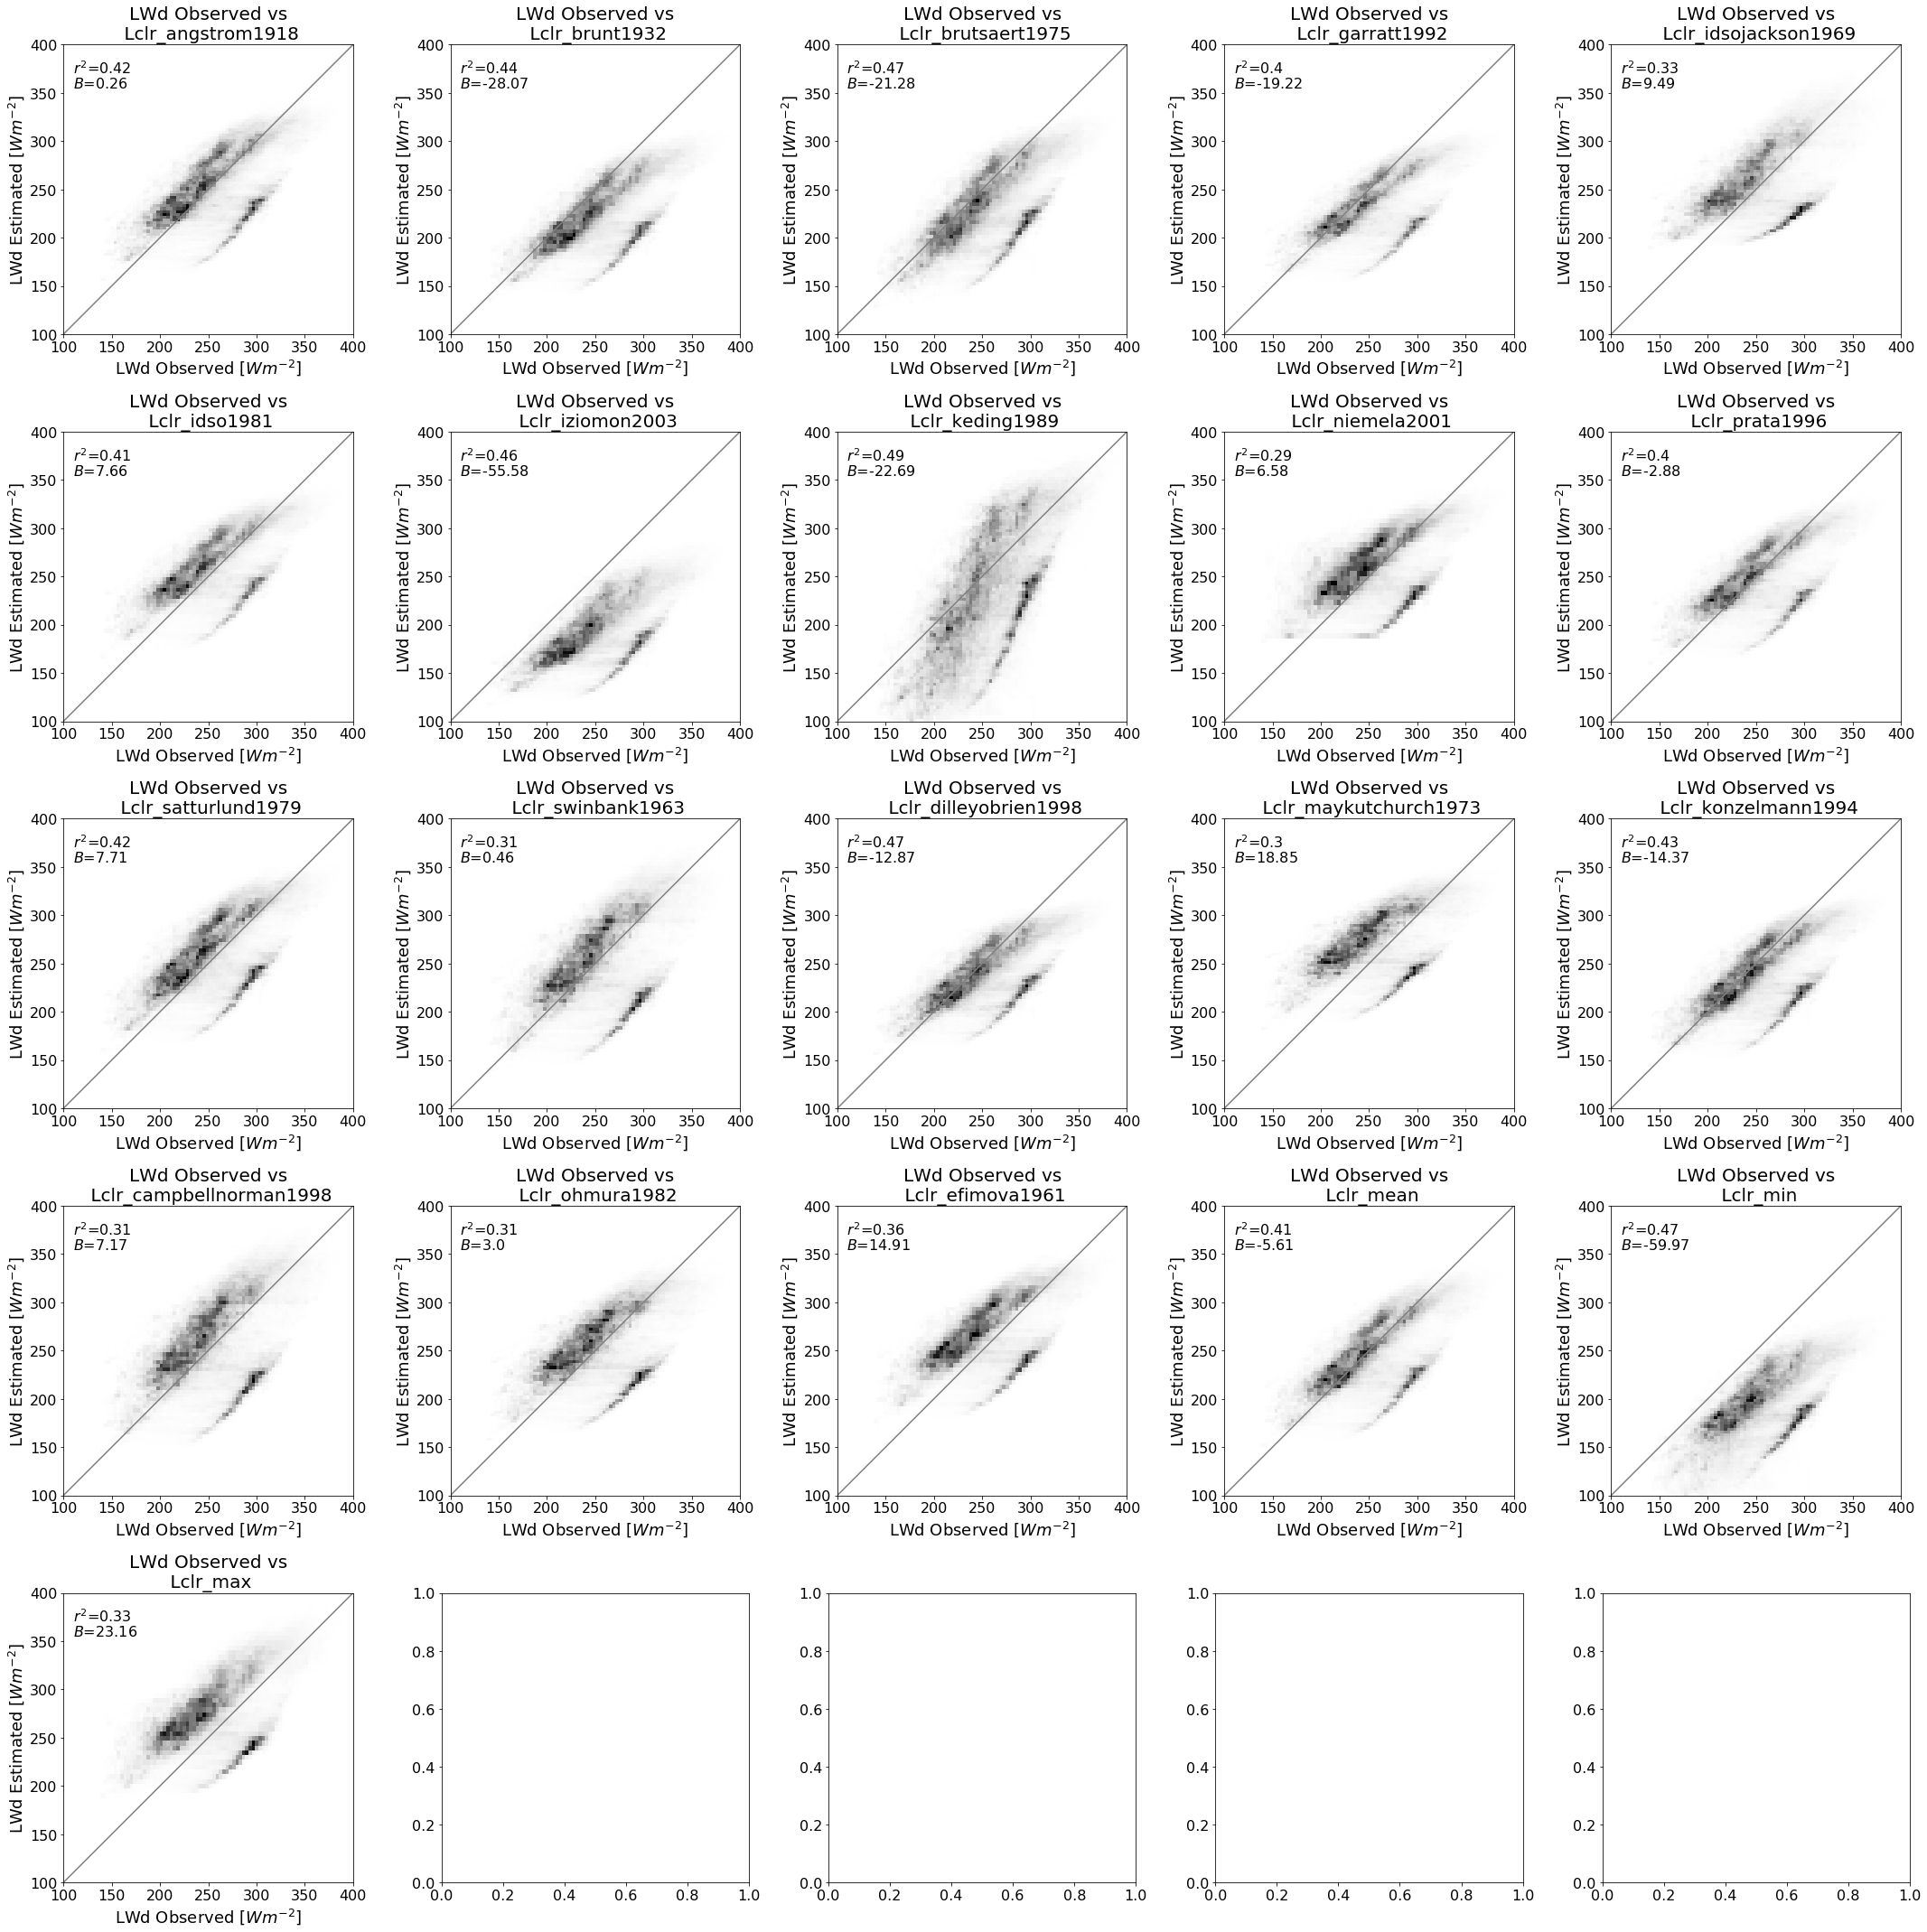

In [15]:
fig, ax = plt.subplots(5,5,figsize=(30,30))
for row in range(0,5):
    for col in range(0,5):
        try:
            plot_2dhist_LWensemble(x,y[(row*5)+col],row,col)
        except IndexError:
            pass
plt.tight_layout()

Plot only for clear-sky conditions (sun flag = 1)

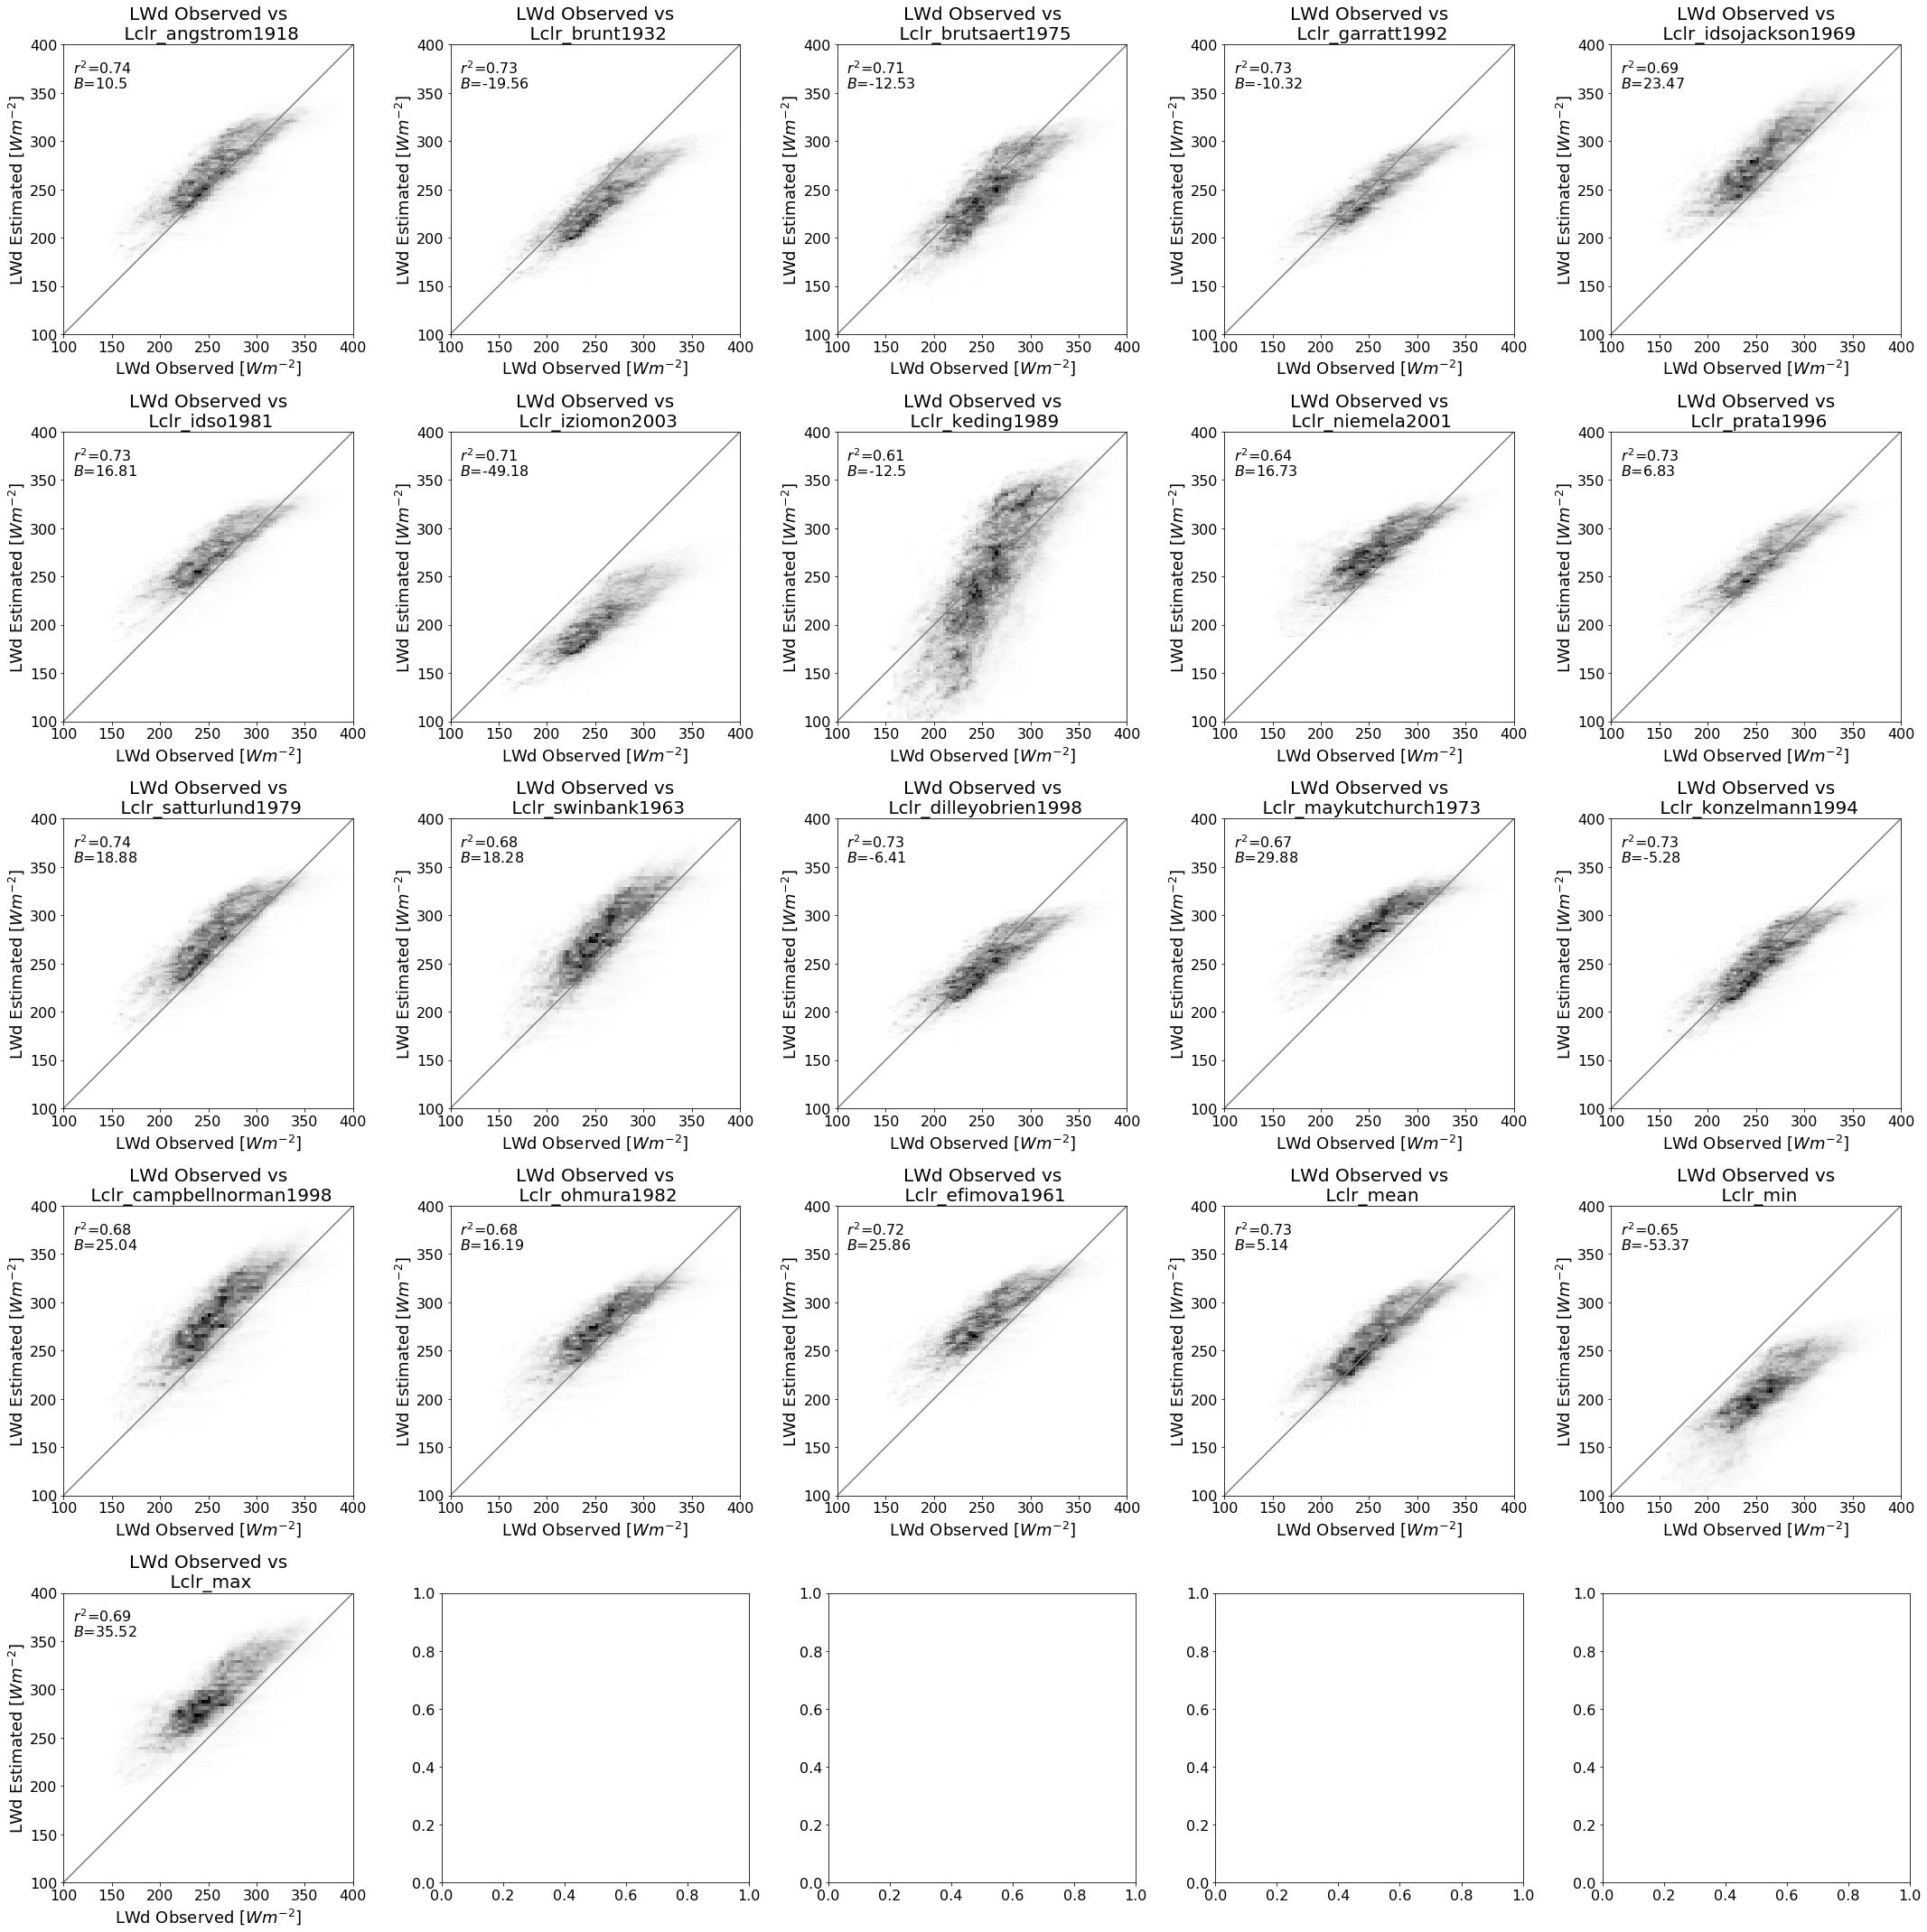

In [19]:
fig, ax = plt.subplots(5,5,figsize=(30,30))
for row in range(0,5):
    for col in range(0,5):
        try:
            plot_2dhist_LWensemble(x.where(cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1),
                                   y[(row*5)+col].where(cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
                                   ,row,col)
        except IndexError:
            pass
plt.tight_layout()

Plot some results zoomed in to a couple days:

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


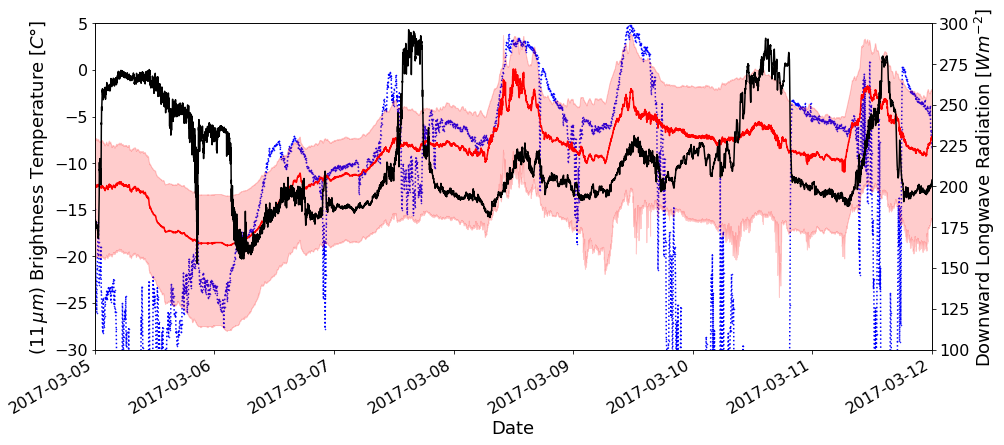

In [20]:
# Set start and end dates for time period we want to look at
startdate = pd.datetime(2017,3,5)
enddate = pd.datetime(2017,3,12)

fig, ax = plt.subplots(figsize=(15,6))


ax2 = ax.twinx()


lw_ensemble.Lclr_mean.plot(ax=ax2,alpha=1,c='r')
ax2.fill_between(lw_ensemble.datetime, lw_ensemble.Lclr_max, lw_ensemble.Lclr_min,color='r',alpha=0.2)


# Observed Downward Lognwave Radiation
cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].plot(ax=ax2, c='k')

# Fill in areas CUES identifies as sunny versus not sunny
#sun_flag = cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] == 1
#cues_nosun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=~sun_flag, color='lightgrey',alpha=0.1)
#cues_sun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=sun_flag, color='lightyellow',alpha=0.1)

#cloud_flag = cues_ds['Lclr'] < cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
#cloud = ax.fill_between(cues_rad_data.datetime, 1000, y2=0, where=cloud_flag, color='red',alpha=0.1)

# GOES brightness temperature
goes_ds.tb.plot(c='b', linestyle=':', marker='.', markersize=1, ax=ax)

#ax.set_xlim((cues_rad.datetime.min(),cues_rad.datetime.max()))
ax.set_xlim([startdate,enddate])
ax2.set_ylim((100,300))
ax.set_ylim((-30,5))

ax.set_ylabel('($11 \, \mu m$) Brightness Temperature [$C\degree$]')
ax.set_xlabel('Date')
ax2.set_ylabel('Downward Longwave Radiation [$W m^{-2}$]');

# make legend
#lines = [ax.lines[0], ax2.lines[0], ax2.lines[1]]
#labels = ['GOES Brightness Temp.', 'Clear-Sky Downward LW', 'CUES: Downward LW']
#ax.legend(lines, labels, loc='upper left')